# Oscilators in Quant Trading Strategies

<a href="https://www.kaggle.com/code/addarm/trading-oscillators-quant" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<!-- @import "[TOC]" {cmd="toc" depthFrom=1 depthTo=6 orderedList=false} -->

![MidJourney oscillations, waves and Charts 2023.11.5](https://raw.githubusercontent.com/adamd1985/quant_research/main/images/ocillatorsBanner.png)

Oscillators are momentum indicators used in quantitative finance to identify turning points. 

Using moving averages and deviations, these gauge peaks and troughs in momentum. Oscillations above and below ranges or centerlines signal **potential** overbought or oversold conditions. Divergences between oscillator signals and price can **guess probabilistic** turning points in asset's trend.

# Common Signals

**Moving Average Convergence Divergence (MACD) or Absolute Price Oscillator (APO)** 

These Calculate the difference between two moving averages to identify momentum and trend changes. 
* Pros: Good for identifying momentum shifts. 
* Cons: Can generate false signals in choppy markets.

Attributes:
* APO is an absolute momentum oscillator while MACD is a relative momentum oscillator. APO is better for identifying trend changes while MACD is better for gauging acceleration. 
* APO is less prone to false signals since it uses raw price, as it osscilates around the 0 centerl-ine.
* MACD has no fixed center-line and oscillates based on its input data, requiring other signals to synergize with this one.

**Relative Strength Index (RSI) or Stochastic Oscillator**
Compares the magnitude of recent gains and losses to identify overbought and oversold conditions. 
* Pros: Good for identifying divergences and potential reversals. 
* Cons: Can stay overbought or oversold for long periods or produce false signals.

Attributes:
* Calculates the ratio of higher closing prices vs lower closing prices over a set period. RSI compares price in a period, Stochastic compares price  in a range.
* Values under the 30s are **usually** considered oversold, and over the 70s signal overbought. Both produce a range of 0 to 100.
* Signals divergences from price action **usually** signal extremes in momentum or reversals.

## Prepare your Environment

Have a jupyter environment ready, and `pip install` these libraries:
- numpy
- pandas
- yfinance


In [45]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os

import dotenv
%load_ext dotenv

IS_KAGGLE = os.getenv('IS_KAGGLE', 'True') == 'True'

if IS_KAGGLE:
    # Kaggle confgs
    print('Running in Kaggle...')
    %pip install yfinance
    %pip install statsmodels
    %pip install seaborn
    %pip install itertools
    %pip install scikit-learn

    for dirname, _, filenames in os.walk('/kaggle/input'):
        for filename in filenames:
            print(os.path.join(dirname, filename))
else:
    print('Running Local...')

import yfinance as yf
from analysis_utils import calculate_profit, load_ticker_ts_df, plot_strategy

The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv
Running Local...


In [46]:
tickers = ['AAPL']

START_DATE = '2021-01-01'
END_DATE = '2023-10-31'
APO_BULL_SIGNAL = 5
APO_BEAR_SIGNAL = -5
APO_FAST_WINDOW = 12
APO_SLOW_WINDOW = 45

ticker = load_ticker_ts_df('AAPL', START_DATE, END_DATE)

# The Components of an APO

1. **Exponential Moving Average (EMA):** A moving average that gives more weight to recent data point:

$$EMA(n) = (Close - EMA(previous, n)) \cdot \frac{2}{n + 1} + EMA(previous, n)$$


1. **fast EMA (fEMA):** Moving Price Average with a 12-day period. Reacts quickly to short-term price changes, sensitive to recent market developments.

2. **slow EMA (sEMA):** Moving Price Average with a 24-day period. Provides a longer-term view of price trends.

The crossover of a fast EMA above a slow EMA can signal a bullish trend, while the opposite can indicate a bearish trend. Here is a visualization below:

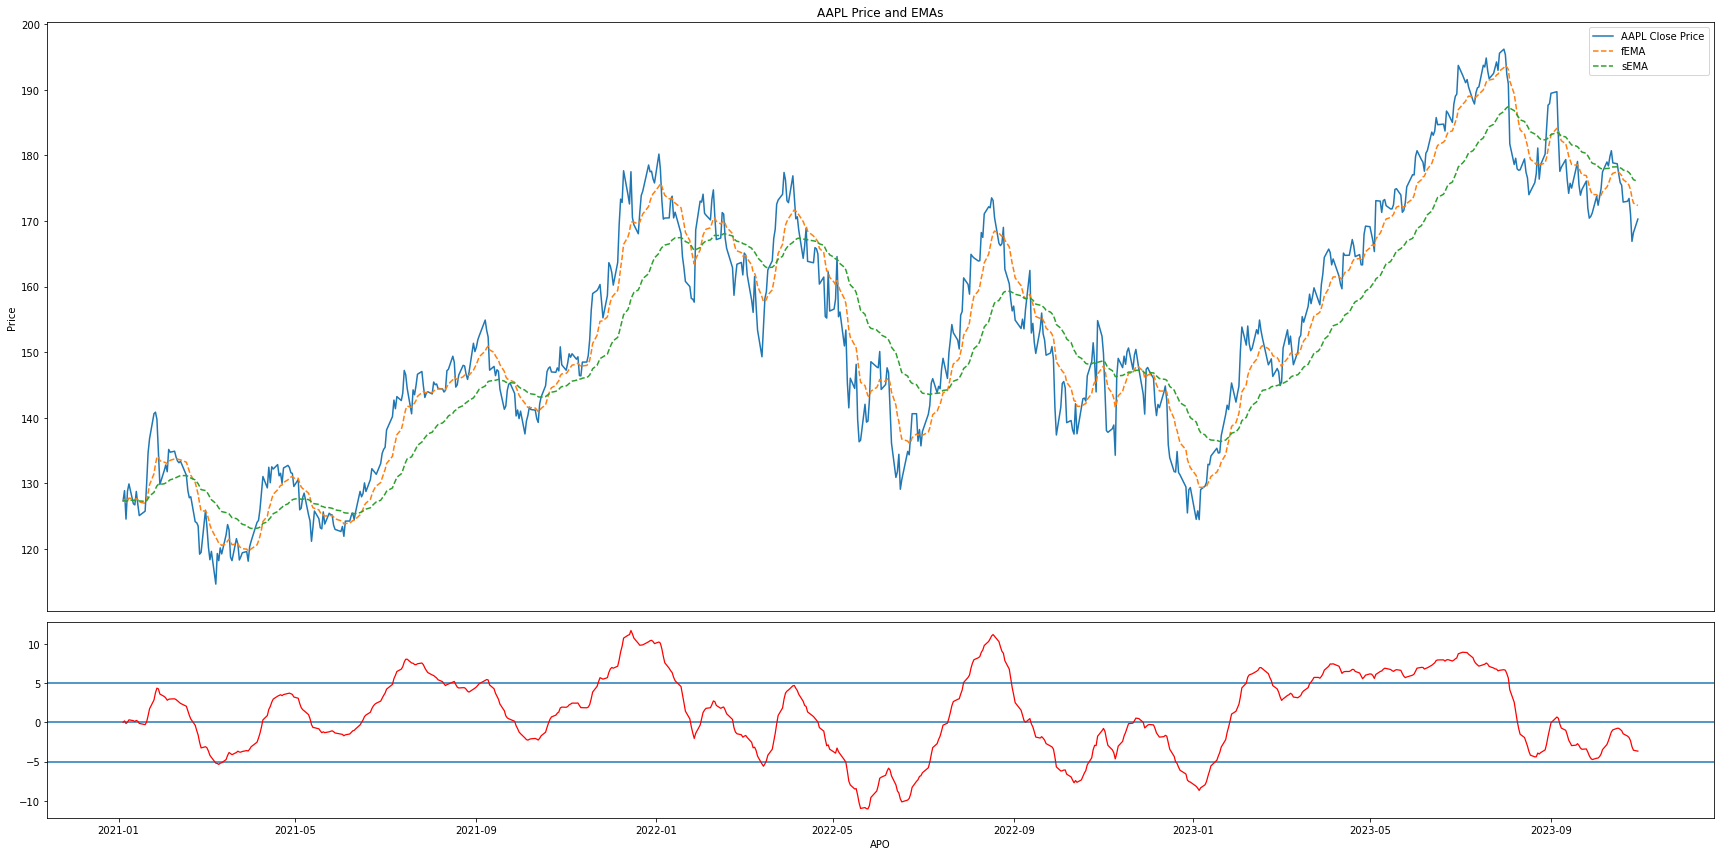

In [47]:
ticker['fEMA'] = ticker['Adj Close'].ewm(
    span=APO_FAST_WINDOW, adjust=False).mean()
ticker['sEMA'] = ticker['Adj Close'].ewm(
    span=APO_SLOW_WINDOW, adjust=False).mean()
ticker['APO'] = ticker['fEMA'] - ticker['sEMA']

fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={
    'height_ratios': (3, 1)}, figsize=(24, 12))
ax1.plot(ticker.index, ticker['Adj Close'], label='AAPL Close Price')
ax1.plot(ticker.index, ticker['fEMA'], label='fEMA', linestyle='--')
ax1.plot(ticker.index, ticker['sEMA'], label='sEMA', linestyle='--')

ax2.axhline(APO_BULL_SIGNAL)
ax2.axhline(0.0)
ax2.axhline(APO_BEAR_SIGNAL)
ax2.plot(ticker.index, ticker['APO'], label='sEMA', lw=1.25, color='r')
ax1.set_title('AAPL Price and EMAs')
ax2.set_xlabel('APO')
ax1.set_ylabel('Price')
ax1.set_xticks([])

ax1.legend()
plt.tight_layout()
plt.show()

With this info, let's build a signal:

c:\Users\worker\workspace\quant_research\analysis_utils.py:45: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  profit = pd.Series(index=prices.index)


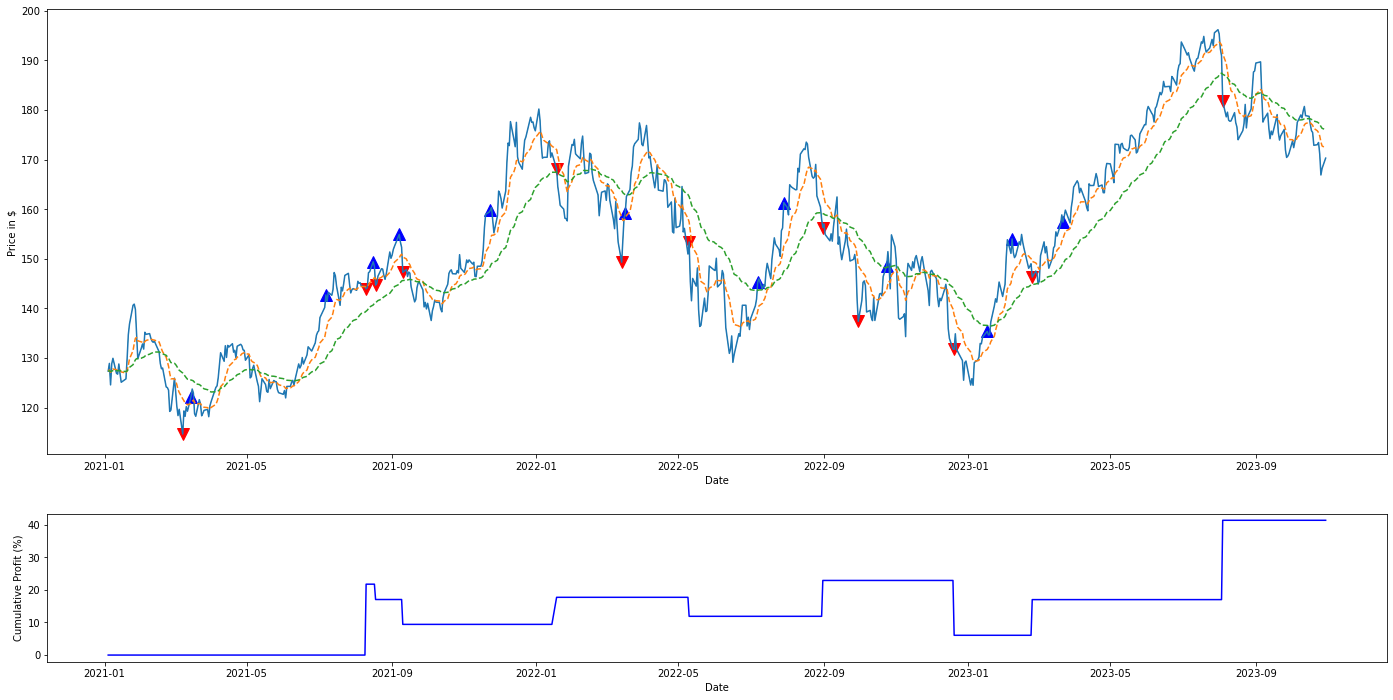

In [48]:
import pandas as pd


def signal_apo_oscillator(ticker_ts, fast_window_size=APO_FAST_WINDOW, slow_window_size=APO_SLOW_WINDOW, buy_threshold=APO_BULL_SIGNAL, sell_threshold=APO_BEAR_SIGNAL):
    fema = ticker_ts['Adj Close'].ewm(
        span=fast_window_size, adjust=False).mean()
    sma = ticker_ts['Adj Close'].ewm(
        span=slow_window_size, adjust=False).mean()
    apo = fema - sma

    signals_df = pd.DataFrame(index=ticker_ts.index)
    signals_df['signal'] = np.where(
        apo >= buy_threshold, 1, np.where(apo <= sell_threshold, -1, 0))
    signals_df['orders'] = signals_df['signal'].diff()
    signals_df.loc[signals_df['orders'] == 0, 'orders'] = None
    return signals_df


signals_df = signal_apo_oscillator(ticker)
profit_series = calculate_profit(signals_df, ticker["Adj Close"])
ax1, ax2 = plot_strategy(ticker["Adj Close"], signals_df, profit_series)
ax1.plot(ticker.index, ticker['Adj Close'], label='AAPL Close Price')
ax1.plot(ticker.index, ticker['fEMA'], label='fEMA', linestyle='--')
ax1.plot(ticker.index, ticker['sEMA'], label='sEMA', linestyle='--')

plt.show()

The strategy generates buy and sell signals based on our threshold values:
`buy_threshold` represents the bullish signal threshold, and `sell_threshold` represents the bearish signal threshold. When our APO crosses any of these thresholds, we will create a signal in the timeseries. 

The `signals_df` DataFrame includes two key columns:
* 'signal': It contains values of 1 (buy), -1 (sell), or 0 (no signal) based on APO conditions.
* 'orders': This column represents changes in trading positions. It is computed as the difference in the 'signal' column and is set to None when no trading position change occurs.

Since all our signals in this series of articles are long only, we will buy on the first buy signal and hold until the first sell signal. That difference is the profit we are charting above. This strategy returned a simulated ~40% in 2 years, against the ~S&P500's 10% - **all on paper**!

# Conclusion

A quant might use these oscillators to catch inflections in the asset's trend and help to gauge closing momentum or if its due for a pullback. Your Youtube fin-crowd would use it to sell you trading courses.

A takeaway on **EMAs**, these help filter out noise in your dataset and provide a clearer picture of trends.

![MidJourney A sad finfluencecr looking at waves 2023.11.5](https://raw.githubusercontent.com/adamd1985/quant_research/main/images/traderLookingAtWaves.png)

## References

- https://www.linkedin.com/pulse/pairs-trading-strategy-every-stock-needs-friend-adam-darmanin-489ff/
- https://www.linkedin.com/pulse/momentum-reversion-poor-mans-trading-strategies-adam-darmanin-vhrif/
- https://www.investopedia.com/terms/o/oscillator.asp
- https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.ewm.html 

## Github

Article here is also available on [Github](https://github.com/adamd1985/quant_research/blob/main/oscilators-quant.ipynb)

Kaggle notebook available [here](https://www.kaggle.com/code/addarm/trading-oscillators-quant)


## Media

All media used (in the form of code or images) are either solely owned by me, acquired through licensing, or part of the Public Domain and granted use through Creative Commons License.

## CC Licensing and Use

<a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/">Creative Commons Attribution-NonCommercial 4.0 International License</a>.